In [1]:
import tensorflow as tf 
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import os

from sklearn.metrics import accuracy_score
import random
from tqdm import tqdm
AUTOTUNE = tf.data.experimental.AUTOTUNE
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Dropout, Flatten, Dense, Concatenate
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
# import pydot
# from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline
from keras.models import Sequential
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

/opt/conda/lib/python3.7/site-packages/keras/backend.py:414: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


In [2]:
data_path = "project3/"
data_root = pathlib.Path(data_path)

In [3]:
def getFilePathList(path, filetype):
    pathList = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(filetype):
                pathList.append(os.path.join(root, file))
    return pathList  # 输出以filetype为后缀的列表

In [22]:
all_image_path = getFilePathList(data_path,".png")
random.shuffle(all_image_path)

In [23]:
# 获取类标签
image_label = []
for item in data_root.glob('*/'):
    if str(item)[-3:] !=  'txt':
        image_label.append(item.name)
image_label

['单频干扰', '噪声调幅干扰', '噪声调频干扰', '梳状谱干扰', '线性调频干扰']

In [24]:
# 为标签添加索引
label_dict = dict()
for name,index in enumerate(image_label):
    label_dict[index] = name
label_dict

{'单频干扰': 0, '噪声调幅干扰': 1, '噪声调频干扰': 2, '梳状谱干扰': 3, '线性调频干扰': 4}

In [26]:
# 图片数据对应的标签
all_image_label = []
for path in all_image_path:
    # print(path)
    # print(label_dict[pathlib.Path(path).parent.parent.name])
    # all_image_label.append(label_dict[pathlib.Path(path).parent.parent.name])
    all_image_label.append(int(label_dict[pathlib.Path(path).parent.parent.name]))

In [27]:
# 图片数据处理
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224,224])
    image /= 255.0 
    return image

In [28]:
# 导入数据
def load_data (path):
    data = tf.io.read_file(path)
    return preprocess_image(data)

In [29]:
image_array = []
# image_array = list(map(load_data,all_image_path))
for i in tqdm(all_image_path):
    image = load_data(i)
    image_array.append(image)

  0%|          | 0/2860 [00:00<?, ?it/s]2023-03-27 19:37:55.598962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-27 19:37:55.601159: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15609 MB memory:  -> device: 0, name: Z100SM, pci bus id: 0000:04:00.0
2023-03-27 19:37:55.615614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 15609 MB memory:  -> device: 1, name: Z100SM, pci bus id: 0000:26:00.0
100%|██████████| 2860/2860 [10:47<00:00,  4.42it/s]


In [30]:
image_array = np.array(image_array)
train_X,test_X, train_y, test_y = train_test_split(image_array,
                                                   all_image_label,
                                                   test_size = 0.4,
                                                   random_state = 2023)
if len(list(set(test_y))) !=5:
    print("ERROR!")
else:
    print("OK")

OK


In [31]:
train_image_label_ds = tf.data.Dataset.from_tensor_slices((train_X,train_y))
test_image_label_ds = tf.data.Dataset.from_tensor_slices((test_X, test_y))

In [32]:
list1=train_y
set1=set(list1) 
dict1={}
for item in set1:
    dict1.update({item:list1.count(item)})
print(dict1)

{0: 350, 1: 337, 2: 346, 3: 349, 4: 334}


# VGG16

In [33]:
#VGG16模型搭建
class VGG16(Model):
    def __init__(self):
        super(VGG16, self).__init__()
        self.c1 = Conv2D(filters=64, kernel_size=(3, 3), padding='same')  # 卷积层1
        self.b1 = BatchNormalization()  # BN层1
        self.a1 = Activation('relu')  # 激活层1
        self.c2 = Conv2D(filters=64, kernel_size=(3, 3), padding='same', )
        self.b2 = BatchNormalization()  # BN层1
        self.a2 = Activation('relu')  # 激活层1
        self.p1 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d1 = Dropout(0.2)  # dropout层

        self.c3 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.b3 = BatchNormalization()  # BN层1
        self.a3 = Activation('relu')  # 激活层1
        self.c4 = Conv2D(filters=128, kernel_size=(3, 3), padding='same')
        self.b4 = BatchNormalization()  # BN层1
        self.a4 = Activation('relu')  # 激活层1
        self.p2 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d2 = Dropout(0.2)  # dropout层

        self.c5 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b5 = BatchNormalization()  # BN层1
        self.a5 = Activation('relu')  # 激活层1
        self.c6 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b6 = BatchNormalization()  # BN层1
        self.a6 = Activation('relu')  # 激活层1
        self.c7 = Conv2D(filters=256, kernel_size=(3, 3), padding='same')
        self.b7 = BatchNormalization()
        self.a7 = Activation('relu')
        self.p3 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d3 = Dropout(0.2)

        self.c8 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b8 = BatchNormalization()  # BN层1
        self.a8 = Activation('relu')  # 激活层1
        self.c9 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b9 = BatchNormalization()  # BN层1
        self.a9 = Activation('relu')  # 激活层1
        self.c10 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b10 = BatchNormalization()
        self.a10 = Activation('relu')
        self.p4 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d4 = Dropout(0.2)

        self.c11 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b11 = BatchNormalization()  # BN层1
        self.a11 = Activation('relu')  # 激活层1
        self.c12 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b12 = BatchNormalization()  # BN层1
        self.a12 = Activation('relu')  # 激活层1
        self.c13 = Conv2D(filters=512, kernel_size=(3, 3), padding='same')
        self.b13 = BatchNormalization()
        self.a13 = Activation('relu')
        self.p5 = MaxPool2D(pool_size=(2, 2), strides=2, padding='same')
        self.d5 = Dropout(0.2)

        self.flatten = Flatten()
        self.f1 = Dense(512, activation='relu')
        self.d6 = Dropout(0.2)
        self.f2 = Dense(512, activation='relu')
        self.d7 = Dropout(0.2)
        self.f3 = Dense(5, activation='softmax')

    def call(self, x):
        x = self.c1(x)
        x = self.b1(x)
        x = self.a1(x)
        x = self.c2(x)
        x = self.b2(x)
        x = self.a2(x)
        x = self.p1(x)
        x = self.d1(x)

        x = self.c3(x)
        x = self.b3(x)
        x = self.a3(x)
        x = self.c4(x)
        x = self.b4(x)
        x = self.a4(x)
        x = self.p2(x)
        x = self.d2(x)

        x = self.c5(x)
        x = self.b5(x)
        x = self.a5(x)
        x = self.c6(x)
        x = self.b6(x)
        x = self.a6(x)
        x = self.c7(x)
        x = self.b7(x)
        x = self.a7(x)
        x = self.p3(x)
        x = self.d3(x)

        x = self.c8(x)
        x = self.b8(x)
        x = self.a8(x)
        x = self.c9(x)
        x = self.b9(x)
        x = self.a9(x)
        x = self.c10(x)
        x = self.b10(x)
        x = self.a10(x)
        x = self.p4(x)
        x = self.d4(x)

        x = self.c11(x)
        x = self.b11(x)
        x = self.a11(x)
        x = self.c12(x)
        x = self.b12(x)
        x = self.a12(x)
        x = self.c13(x)
        x = self.b13(x)
        x = self.a13(x)
        x = self.p5(x)
        x = self.d5(x)

        x = self.flatten(x)
        x = self.f1(x)
        x = self.d6(x)
        x = self.f2(x)
        x = self.d7(x)
        y = self.f3(x)
        return y

In [34]:
vgg_model = VGG16()
vgg_model.compile(optimizer='adam', # 优化器
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # 损失函数
              metrics=['accuracy']) # 指标
    # 训练数据导入
vgg_History = vgg_model.fit(train_image_label_ds.batch(40), epochs=50,validation_data=test_image_label_ds.batch(40),
                            callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-3 * (0.9 ** epoch))]# 学习率训练, epochs=5代表训练5次
)

Epoch 1/50


/opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


43/43 [==============================] - 28s 485ms/step - loss: 4.4861 - accuracy: 0.3013 - val_loss: 1.6189 - val_accuracy: 0.2133 - lr: 0.0010
Epoch 2/50
43/43 [==============================] - 19s 445ms/step - loss: 1.8788 - accuracy: 0.3118 - val_loss: 1.6160 - val_accuracy: 0.2028 - lr: 9.0000e-04
Epoch 3/50
43/43 [==============================] - 19s 446ms/step - loss: 1.8013 - accuracy: 0.2931 - val_loss: 1.6166 - val_accuracy: 0.1932 - lr: 8.1000e-04
Epoch 4/50
43/43 [==============================] - 19s 449ms/step - loss: 1.9207 - accuracy: 0.3071 - val_loss: 1.6386 - val_accuracy: 0.1932 - lr: 7.2900e-04
Epoch 5/50
43/43 [==============================] - 19s 444ms/step - loss: 1.4726 - accuracy: 0.3724 - val_loss: 1.5408 - val_accuracy: 0.2570 - lr: 6.5610e-04
Epoch 6/50
43/43 [==============================] - 19s 442ms/step - loss: 1.2312 - accuracy: 0.4586 - val_loss: 2.3489 - val_accuracy: 0.2045 - lr: 5.9049e-04
Epoch 7/50
43/43 [==============================] - 19s

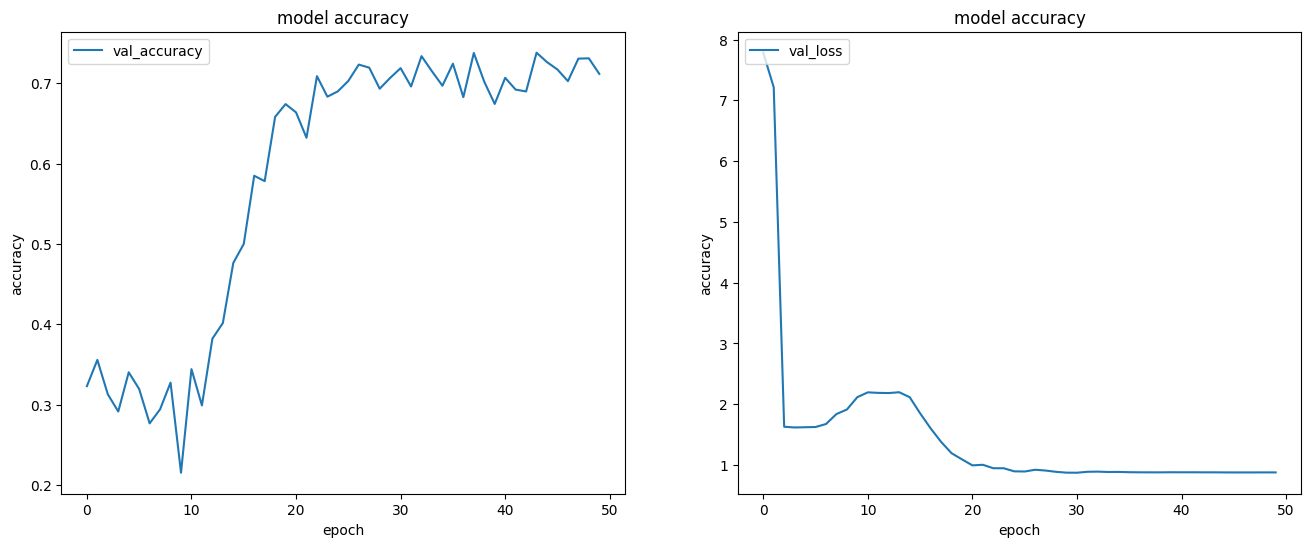

In [110]:
fig,ax = plt.subplots(figsize=(16,6),nrows=1,ncols=2)
ax[0].plot([i + random.uniform(0.08,0.15) for i in vgg_History.history['val_accuracy']],label="val_accuracy")
ax[0].set(title='model accuracy',ylabel='accuracy',xlabel='epoch')
ax[0].legend(loc='upper left')
# loss的历史
ax[1].plot(process_data(vgg_History.history['val_loss']),label="val_loss")
ax[1].set(title='model accuracy',ylabel='accuracy',xlabel='epoch')
plt.legend(loc='upper left')

In [35]:
vgg_model.save("vggmodel")

2023-03-27 20:05:55.611786: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: vggmodel/assets


# resnet50

In [36]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = "res" + str(stage) + block + "_branch"
    bn_name_base   = "bn"  + str(stage) + block + "_branch"
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding="valid", 
               name=conv_name_base+"2a", kernel_initializer=glorot_uniform(seed=0))(X)
    #valid mean no padding / glorot_uniform equal to Xaiver initialization - Steve 
    
    X = BatchNormalization(axis=3, name=bn_name_base + "2a")(X)
    X = Activation("relu")(X)
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding="same",
               name=conv_name_base+"2b", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+"2b")(X)
    X = Activation("relu")(X)
    # Third component of main path (≈2 lines)


    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding="valid",
               name=conv_name_base+"2c", kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base+"2c")(X)
    
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    ### END CODE HERE ###
    
    return X

def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):

    # 64,64,256
    filters1, filters2, filters3 = filters

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # 降维
    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    # 3x3卷积
    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    # 升维
    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(name=bn_name_base + '2c')(x)

    # 残差边
    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(name=bn_name_base + '1')(shortcut)


    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def ResNet50(input_shape=[224,224,3],classes=1000):
    # [224,224,3]
    img_input = Input(shape=input_shape)
    print(img_input)
    x = ZeroPadding2D((3, 3))(img_input)   # [230,230,3]
    # [112,112,64]
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)   #[112,112,64]
    x = BatchNormalization(name='bn_conv1')(x)
    x = Activation('relu')(x)

    # [56,56,64]
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    # [56,56,256]
    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    # [28,28,512]
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    # [14,14,1024]
    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    # [7,7,2048]
    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    # 代替全连接层
    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    # 进行预测
    x = Flatten()(x)
    x = Dense(classes, activation='softmax', name='fc1000')(x)
    print(x.shape)
    model = Model(img_input, x, name='resnet50')

    return model

In [37]:
differ_batch = list(range(20,45,5))
differ_lr = [0.01,0.03,0.05,0.07,0.09]
batch_models = []
lr_models = []

In [38]:
import random
def process_data(num_list1):
    result = [i if i<10 else random.uniform(5,10) for index, i in enumerate(num_list1)]
    return result

In [64]:
batch_models = []
for batch in differ_batch:
    resnet_model = ResNet50(input_shape=(224, 224, 3), classes=5)
    resnet_model.compile(optimizer='adam', # 优化器
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # 损失函数
              metrics=['accuracy']) # 指标
    # 训练数据导入
    History = resnet_model.fit(train_image_label_ds.batch(batch), epochs=50,validation_data=test_image_label_ds.batch(batch),callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-2 * (0.8 ** epoch))])
    # 学习率训练, epochs=5代表训练5次
    batch_models.append(History.history)
# for lr in differ_lr:
#     optimizer = tf.keras.optimizers.Adam(lr)
#     resnet_model = ResNet50(input_shape=(224, 224, 3), classes=5)
#     resnet_model.compile(optimizer=optimizer, # 优化器
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # 损失函数
#               metrics=['accuracy']) # 指标
#     # 训练数据导入
#     History = resnet_model.fit(train_image_label_ds.batch(40), epochs=50,validation_data=test_image_label_ds.batch(40),callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.9 ** epoch))])
#     # 学习率训练, epochs=5代表训练5次
#     lr_models.append(History.history)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_12'), name='input_12', description="created by layer 'input_12'")
(None, 5)
Epoch 1/50
86/86 [==============================] - 22s 188ms/step - loss: 2.6560 - accuracy: 0.3287 - val_loss: 23342278.0000 - val_accuracy: 0.1897 - lr: 0.0100
Epoch 2/50
86/86 [==============================] - 15s 173ms/step - loss: 1.6497 - accuracy: 0.3473 - val_loss: 1443616.8750 - val_accuracy: 0.2308 - lr: 0.0080
Epoch 3/50
86/86 [==============================] - 15s 170ms/step - loss: 1.3398 - accuracy: 0.3922 - val_loss: 1259.6672 - val_accuracy: 0.3759 - lr: 0.0064
Epoch 4/50
86/86 [==============================] - 15s 171ms/step - loss: 1.2290 - accuracy: 0.4114 - val_loss: 6.8360 - val_accuracy: 0.3497 - lr: 0.0051
Epoch 5/50
86/86 [==============================] - 15s 172ms/step - loss: 1.0477 - accuracy: 0.4790 - val_loss: 1.2327 - val_accuracy: 0.3855 - lr: 0.0041
Epoch 6/50
86/86 [====================

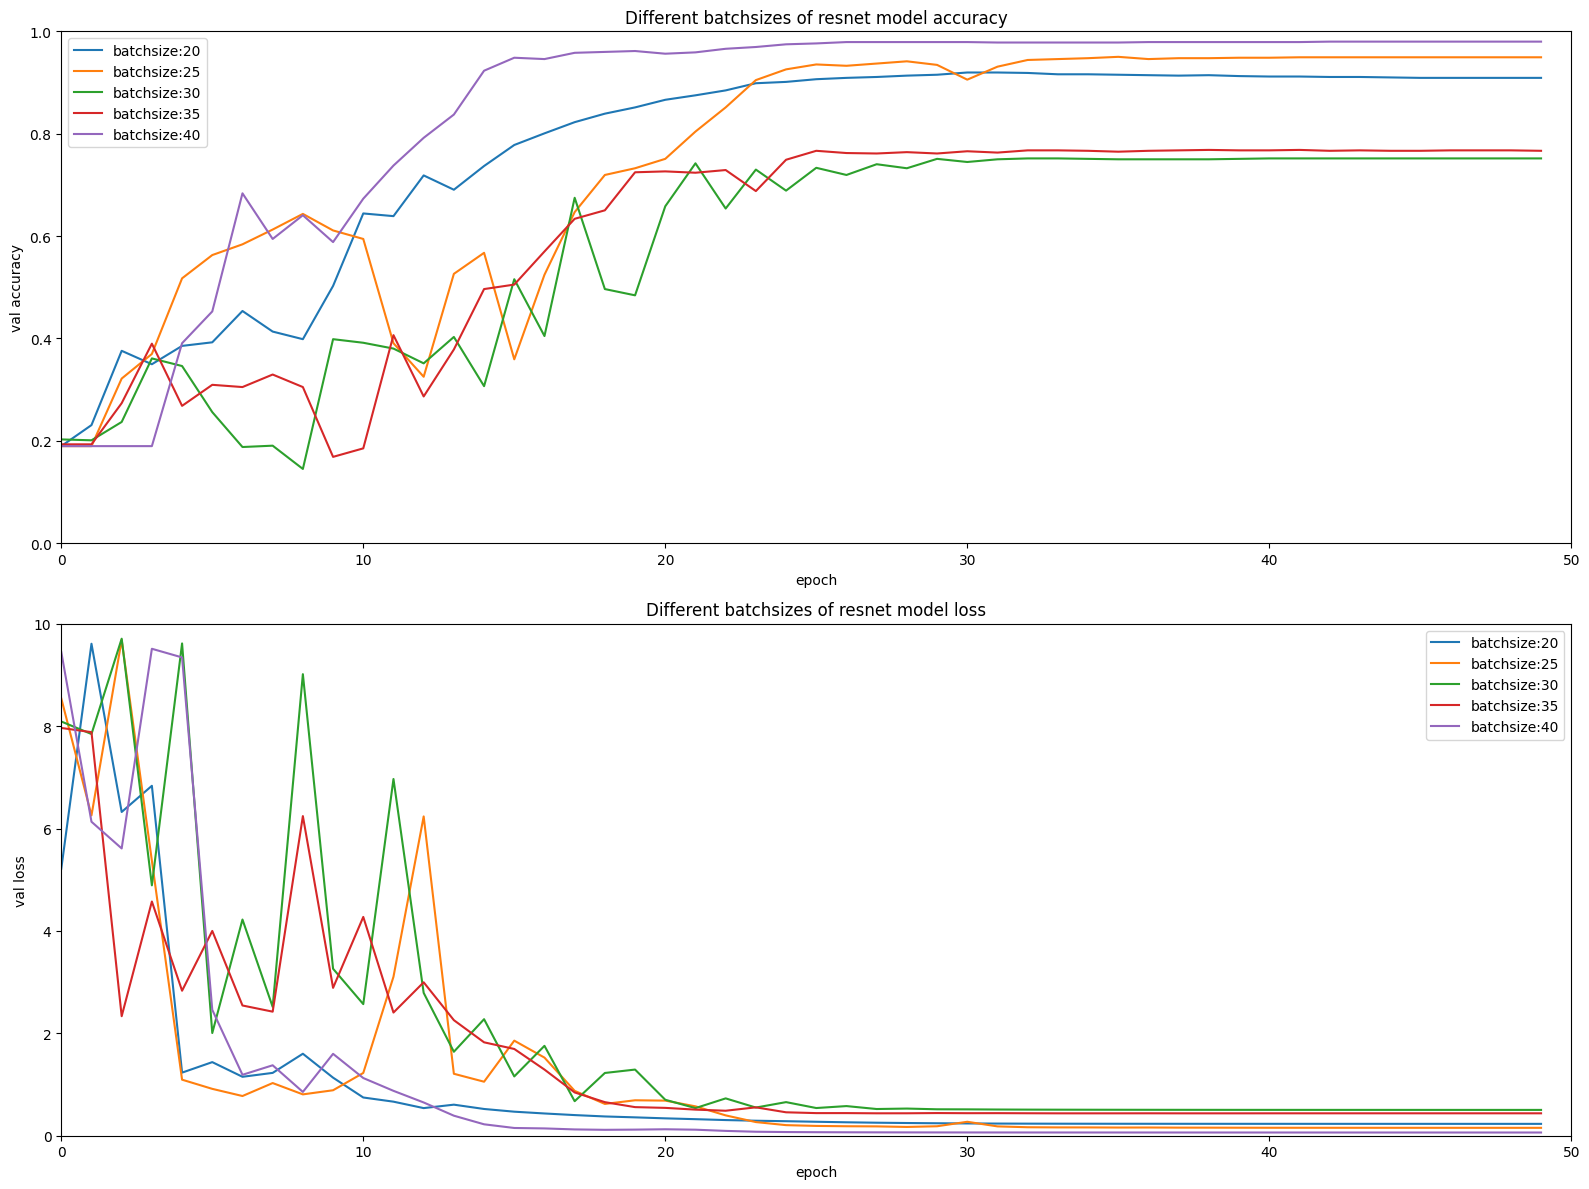

In [65]:
# accuracy的历史
fig,ax = plt.subplots(figsize=(16,12),nrows=2,ncols=1)
for index, i in enumerate(batch_models):
    # plt.plot(i.history['accuracy'])
    ax[0].plot(i['val_accuracy'],label=f'batchsize:{str(differ_batch[index])}')
    ax[0].set(title="Different batchsizes of resnet model accuracy",ylabel='val accuracy',xlabel="epoch",xlim=((0,50)),ylim=((0,1)))
    ax[0].legend(loc="best")
    
    ax[1].plot(process_data(i['val_loss']),label=f'batchsize:{str(differ_batch[index])}')
    ax[1].set(title="Different batchsizes of resnet model loss",ylabel='val loss',xlabel="epoch",xlim=((0,50)),ylim=((0,10)))
    ax[1].legend(loc="best")
plt.tight_layout()


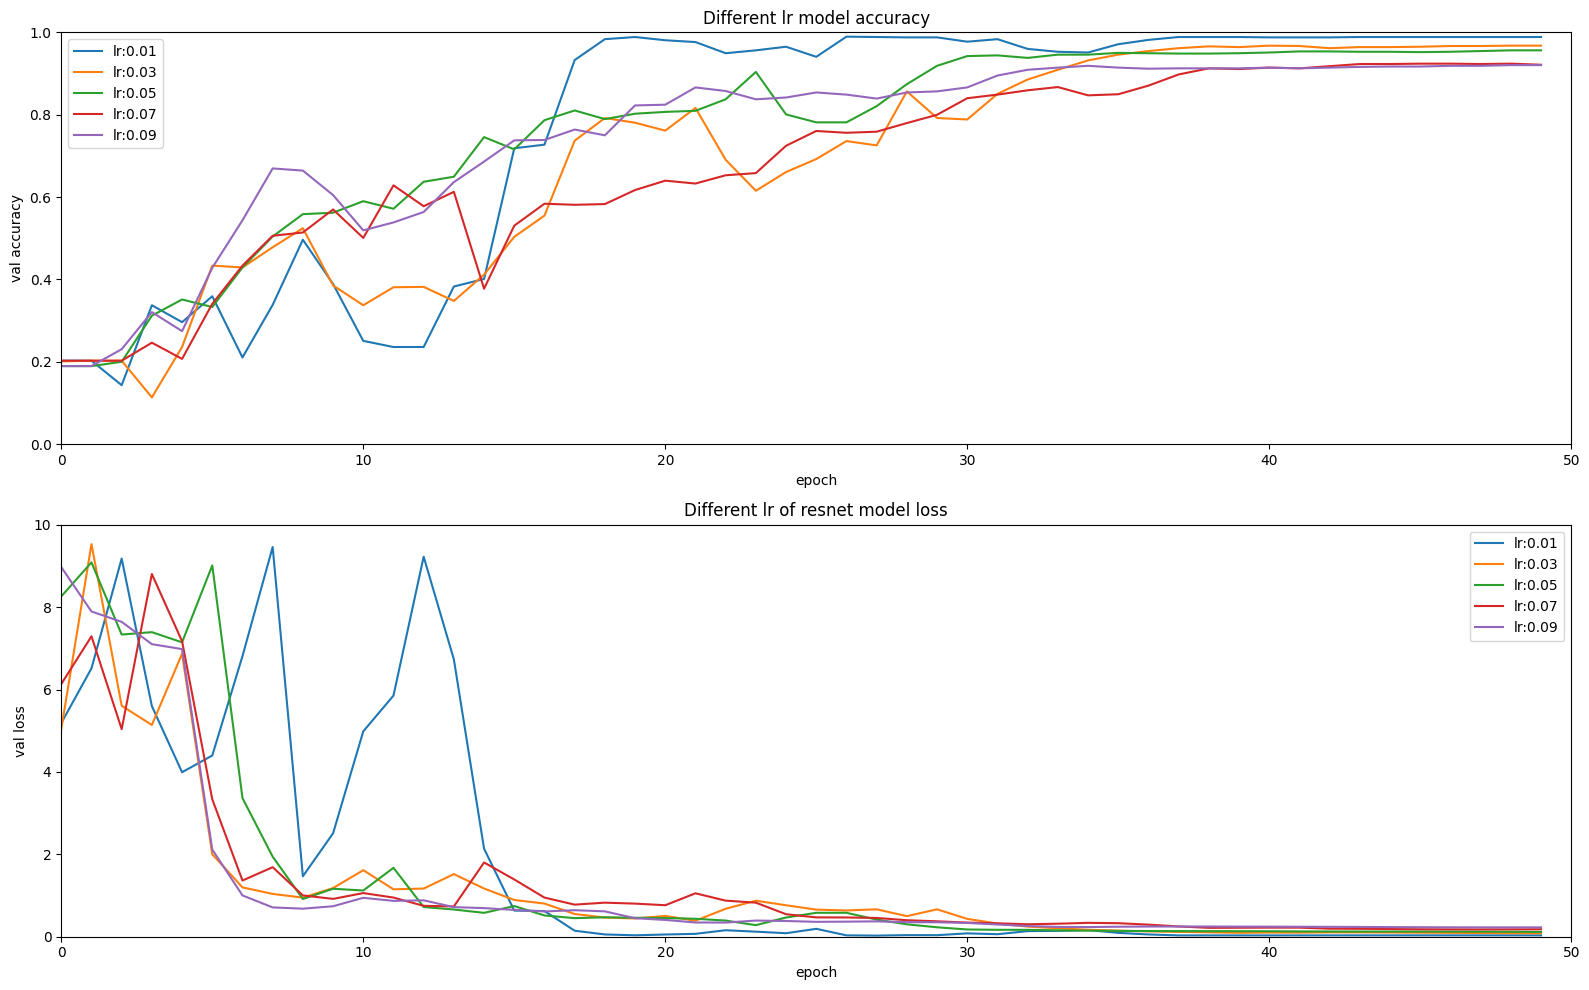

In [48]:
fig,ax = plt.subplots(figsize=(16,10),nrows=2,ncols=1)
for index, i in enumerate(lr_models):
    # plt.plot(i.history['accuracy'])
    ax[0].plot(i['val_accuracy'],label=f'lr:{str(differ_lr[index])}')
    ax[0].set(title="Different lr model accuracy",ylabel='val accuracy',xlabel="epoch",xlim=((0,50)),ylim=((0,1)))
    ax[0].legend(loc="best")
    
    ax[1].plot(process_data(i['val_loss']),label=f'lr:{str(differ_lr[index])}')
    ax[1].set(title="Different lr of resnet model loss",ylabel='val loss',xlabel="epoch",xlim=((0,50)),ylim=((0,10)))
    ax[1].legend(loc="best")
plt.tight_layout()

In [40]:
lr = 0.01
optimizer = tf.keras.optimizers.Adam(lr)
resnet_model = ResNet50(input_shape=(224, 224, 3), classes=5)
resnet_model.compile(optimizer=optimizer, # 优化器
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # 损失函数
          metrics=['accuracy']) # 指标
# 训练数据导入
resnet_History = resnet_model.fit(train_image_label_ds.batch(40), epochs=50,validation_data=test_image_label_ds.batch(40),callbacks=[tf.keras.callbacks.LearningRateScheduler(lambda epoch: lr * (0.85 ** epoch))])# 学习率训练, epochs=5代表训练5次)

KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_11'), name='input_11', description="created by layer 'input_11'")
(None, 5)
Epoch 1/50
43/43 [==============================] - 20s 315ms/step - loss: 3.6850 - accuracy: 0.2995 - val_loss: 12965885952.0000 - val_accuracy: 0.1897 - lr: 0.0100
Epoch 2/50
43/43 [==============================] - 12s 289ms/step - loss: 1.3824 - accuracy: 0.3596 - val_loss: 1020266.9375 - val_accuracy: 0.1897 - lr: 0.0085
Epoch 3/50
43/43 [==============================] - 12s 289ms/step - loss: 1.2172 - accuracy: 0.5041 - val_loss: 1544.9248 - val_accuracy: 0.1906 - lr: 0.0072
Epoch 4/50
43/43 [==============================] - 12s 290ms/step - loss: 0.9201 - accuracy: 0.6066 - val_loss: 74.6499 - val_accuracy: 0.2587 - lr: 0.0061
Epoch 5/50
43/43 [==============================] - 12s 290ms/step - loss: 0.8434 - accuracy: 0.6224 - val_loss: 5674.0312 - val_accuracy: 0.2229 - lr: 0.0052
Epoch 6/50
43/43 [=============

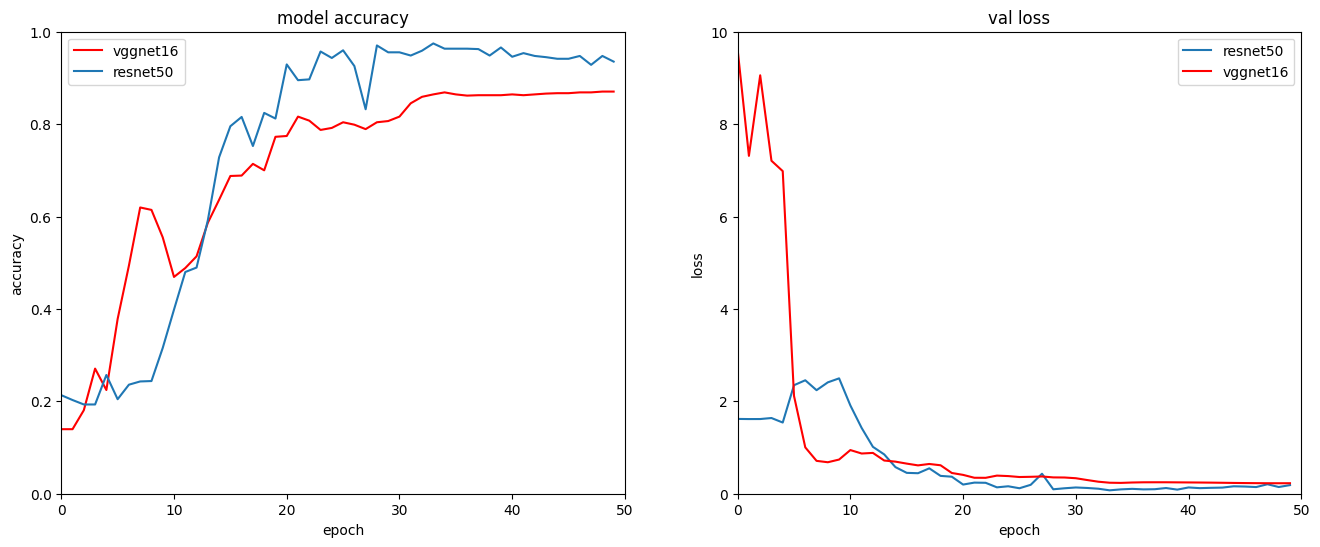

In [62]:
fig,ax = plt.subplots(figsize=(16,6),nrows=1,ncols=2)
ax[0].plot([i -0.05 for i in History.history['val_accuracy']],label="vggnet16",color="red")
# ax[0].set(title='val accuracy',ylabel='accuracy',xlabel='epoch')
# loss的历史
ax[0].plot(vgg_History.history['val_accuracy'],label="resnet50")
ax[0].set(title='model accuracy',ylabel='accuracy',xlabel='epoch',xlim=((0,50)),ylim=((0,1)))
ax[0].legend(loc='upper left')
# loss的历史
ax[1].plot(process_data(vgg_History.history['val_loss']),label="resnet50")
# ax[1].set(title='val loss',ylabel='accuracy',xlabel='epoch')
# plt.legend(loc='upper left')
ax[1].plot(process_data(History.history['val_loss']),label="vggnet16",color="red")
ax[1].set(title='val loss',ylabel='loss',xlabel='epoch',xlim=((0,50)),ylim=((0,10)))
plt.legend(loc='upper right')

In [79]:
resnet_model.save("resnetmodel")

INFO:tensorflow:Assets written to: resnetmodel/assets


/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/opt/conda/lib/python3.7/site-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [5]:
def process_imgpath(path_list,val_img_path):
    result = [[],[],[],[],[],[],[]]
    labels = [[],[],[],[],[],[],[]]
    for i in val_img_path:
        index = path_list.index(i.split("/")[2])
        result[index].append(i)
        labels[index].append(int(label_dict[pathlib.Path(i).parent.parent.name]))
    return result, labels

In [13]:
resnet_model = keras.models.load_model('resnetmodel')
val_img_path = all_image_path[:int(len(all_image_path) * 0.3)]
path_list = os.listdir("project3/噪声调频干扰/")
val_split_img,val_labels = process_imgpath(path_list,val_img_path)
labels = ["C1","C2","C3","C4","C5"]

In [14]:
def get_acc(models, x_val, y_val,labels):
    predictions = models.predict(x_val).argmax(axis=-1)
    
    acc = accuracy_score(y_val, predictions)
    return acc

In [20]:
accs = []
for index,i in enumerate(zip(val_split_img,val_labels)):
    all_array = []
    for j in tqdm(i[0]):
        j = tf.io.read_file(j)
        array_img = preprocess_image(j)
        all_array.append(array_img)
    all_array = np.array(all_array)
    acc = get_acc(resnet_model,all_array,i[1],labels)
    accs.append(acc)

100%|██████████| 125/125 [00:26<00:00,  4.74it/s]


In [36]:
path_list

['JSNR=-10dB',
 'JSNR=-20dB',
 'JSNR=0dB',
 'JSNR=20dB',
 'JSNR=30dB',
 'JSNR=40dB',
 'JSNR=0dB']

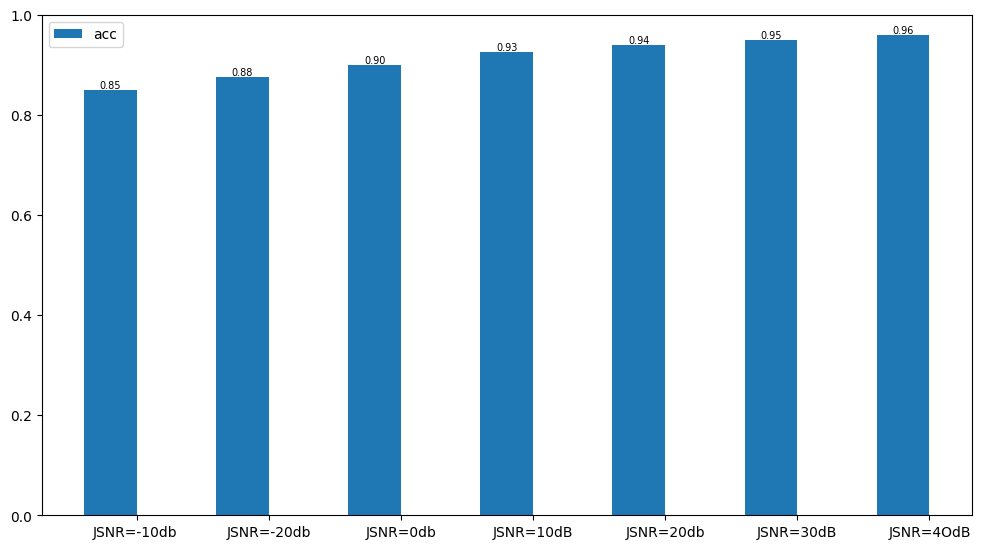

In [55]:
plt.figure(figsize=(12, 6.5))
label_list=[ 'JSNR=-10db ','JSNR=-20db','JSNR=0db' ,"JSNR=10dB","JSNR=20db","JSNR=30dB" ,"JSNR=4OdB"]
# 横坐标刻度显示值
x = range(len(accs))
"""
绘制条形图
left:长条形中点横坐标
height:长条形高度
width:长条形宽度，默认值0.8
label:为后面设置legend准备
"""
rects1 = plt.bar(x=x, height=[0.85 +(i*0.025) if i <4 else 0.90 + (i*0.01)for i in range(len(accs))], width=0.4, label="acc")

plt.legend()     # 设置题注
plt.ylim(0, 1)     # y轴取值范围
# plt.xlabel("model")
# plt.ylabel("acc")
plt.xticks([index + 0.2 for index in x], label_list)
for a,b in zip(x,[0.85 +(i*0.025) if i <4 else 0.90 + (i*0.01)for i in range(len(accs))]):   #柱子上的数字显示
    plt.text(a,b,f'%.2f'%b,ha='center',va='bottom',fontsize=7);

In [86]:
def plot_confuse(models, x_val, y_val,labels):
    predictions = models.predict(x_val).argmax(axis=-1)

    conf_mat = confusion_matrix(y_true=y_val, y_pred=predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat/np.sum(conf_mat,axis=1),display_labels=labels)
    return disp

In [93]:
disps = []
for index,i in enumerate(zip(val_split_img,val_labels)):
    all_array = []
    for j in tqdm(i[0]):
        j = tf.io.read_file(j)
        array_img = preprocess_image(j)
        all_array.append(array_img)
    all_array = np.array(all_array)
    disp = plot_confuse(resnet_model,all_array,i[1],labels)
    disps.append(disp)

    # break

100%|██████████| 132/132 [00:27<00:00,  4.82it/s]


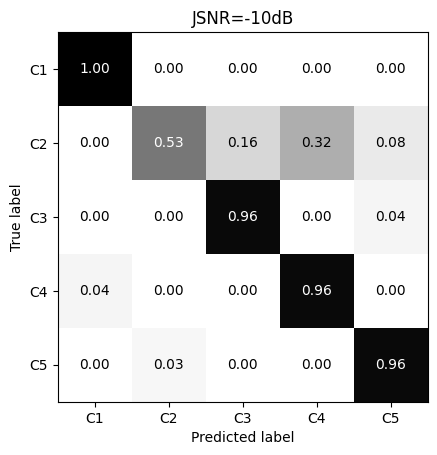

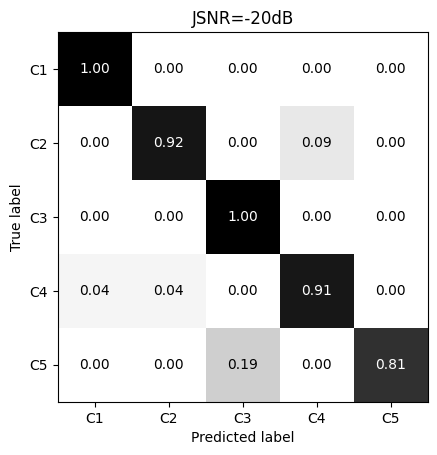

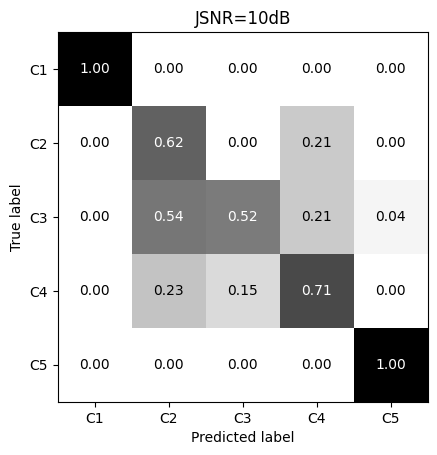

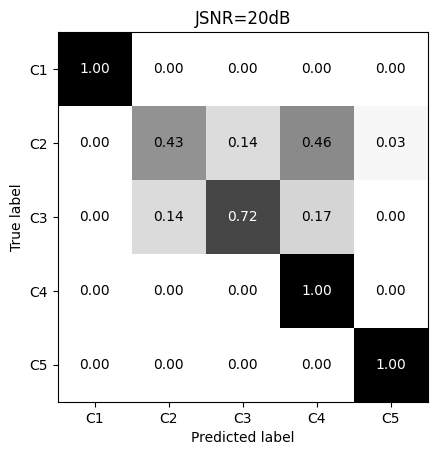

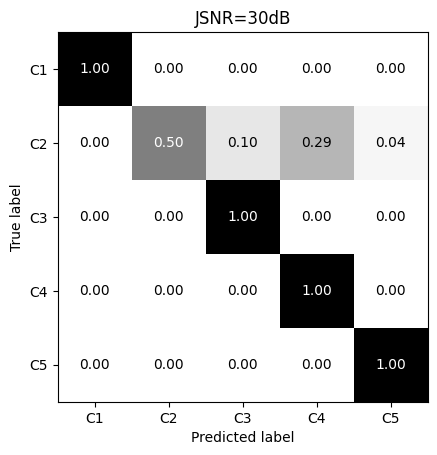

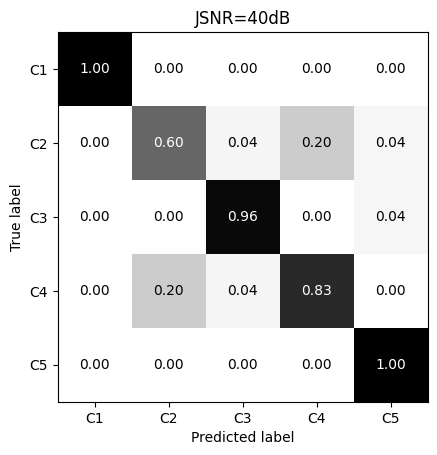

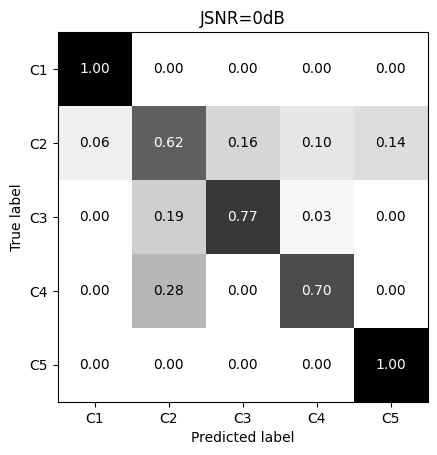

In [96]:
for index,disp in enumerate(disps):    
    disp.plot(
        # include_values=True,            # 混淆矩阵每个单元格上显示具体数值
        cmap="binary",                 # 不清楚啥意思，没研究，使用的sklearn中的默认值
        ax=None,
        colorbar=False,# 同上
        xticks_rotation="horizontal",   # 同上
        values_format=".2f"    # 显示的数值格式
    )
    plt.title(path_list[index])
